## Variational Inference

The dataset required is small and is available preprocessed here:

- https://drive.google.com/drive/folders/1Tg_3SlKbdv0pDog6k2ys0J79e1-vgRyd?usp=sharing

In [1]:
import torch
import numpy as np
from gpytorch.optim import NGD
from torch.optim import Adam
from torch.nn import Parameter
from matplotlib import pyplot as plt

from alfi.datasets import P53Data
from alfi.configuration import VariationalConfiguration
from alfi.models import OrdinaryLFM, TrainMode, generate_multioutput_gp
from alfi.plot import Plotter1d, Colours, tight_kwargs
from alfi.trainers import VariationalTrainer, PreEstimator

Let's start by importing our dataset...

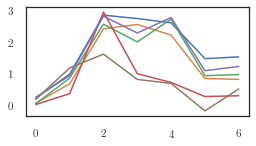

In [2]:
dataset = P53Data(replicate=0, data_dir='../../../data')
ground_truths = P53Data.params_ground_truth()
class ConstrainedTrainer(VariationalTrainer):
    def after_epoch(self):
        with torch.no_grad():
            sens = torch.tensor(1.)
            dec = torch.tensor(0.8)
            self.lfm.raw_sensitivity[3] = self.lfm.positivity.inverse_transform(sens)
            self.lfm.raw_decay[3] = self.lfm.positivity.inverse_transform(dec)
        super().after_epoch()

num_genes = 5
num_tfs = 1

plt.figure(figsize=(4, 2))
for i in range(5):
    plt.plot(dataset[i][1])
plt.plot(dataset.f_observed[0, 0])
t_end = dataset.t_observed[-1]

We use the ordinary differential equation (ODE):

`dy/dt = b + sf(t) - dy`

`f(t) ~ GP(0, k(t, t'))`

Since this is an ODE, we inherit from the `OrdinaryLFM` class.

In [3]:
from gpytorch.constraints import Positive
class TranscriptionLFM(OrdinaryLFM):
    def __init__(self, num_outputs, gp_model, config: VariationalConfiguration, **kwargs):
        super().__init__(num_outputs, gp_model, config, **kwargs)
        self.positivity = Positive()
        self.raw_decay = Parameter(
            self.positivity.inverse_transform(0.1 + torch.rand(torch.Size([self.num_outputs, 1]), dtype=torch.float64)))
        self.raw_basal = Parameter(
            self.positivity.inverse_transform(0.1 * torch.rand(torch.Size([self.num_outputs, 1]), dtype=torch.float64)))
        self.raw_sensitivity = Parameter(
            self.positivity.inverse_transform(2*torch.rand(torch.Size([self.num_outputs, 1]), dtype=torch.float64)))

    @property
    def decay_rate(self):
        return self.positivity.transform(self.raw_decay)

    @decay_rate.setter
    def decay_rate(self, value):
        self.raw_decay = self.positivity.inverse_transform(value)

    @property
    def basal_rate(self):
        return self.positivity.transform(self.raw_basal)

    @basal_rate.setter
    def basal_rate(self, value):
        self.raw_basal = self.positivity.inverse_transform(value)

    @property
    def sensitivity(self):
        return self.positivity.transform(self.raw_sensitivity)

    @sensitivity.setter
    def sensitivity(self, value):
        self.raw_sensitivity = self.decay_constraint.inverse_transform(value)

    def initial_state(self):
        return self.basal_rate / self.decay_rate

    def odefunc(self, t, h):
        """h is of shape (num_samples, num_outputs, 1)"""
        self.nfe += 1
        # if (self.nfe % 100) == 0:
        #     print(t)
        f = self.f
        if not (self.train_mode == TrainMode.GRADIENT_MATCH):
            f = self.f[:, :, self.t_index].unsqueeze(2)
            if t > self.last_t:
                self.t_index += 1
            self.last_t = t

        dh = self.basal_rate + self.sensitivity * f - self.decay_rate * h
        return dh

In [4]:
config = VariationalConfiguration(
    preprocessing_variance=dataset.variance,
    num_samples=80,
    initial_conditions=False
)

num_inducing = 20  # (I x m x 1)
inducing_points = torch.linspace(0, t_end, num_inducing).repeat(num_tfs, 1).view(num_tfs, num_inducing, 1)
t_predict = torch.linspace(0, t_end+2, 80, dtype=torch.float32)
step_size = 5e-1
num_training = dataset.m_observed.shape[-1]
use_natural = True
gp_model = generate_multioutput_gp(num_tfs, inducing_points, gp_kwargs=dict(natural=use_natural))

lfm = TranscriptionLFM(num_genes, gp_model, config, num_training_points=num_training)
plotter = Plotter1d(lfm, dataset.gene_names, style='seaborn')

In [5]:
track_parameters = [
    'raw_basal',
    'raw_decay',
    'raw_sensitivity',
    'gp_model.covar_module.raw_lengthscale',
]
if use_natural:
    variational_optimizer = NGD(lfm.variational_parameters(), num_data=num_training, lr=0.09)
    parameter_optimizer = Adam(lfm.nonvariational_parameters(), lr=0.02)
    optimizers = [variational_optimizer, parameter_optimizer]
    pre_variational_optimizer = NGD(lfm.variational_parameters(), num_data=num_training, lr=0.1)
    pre_parameter_optimizer = Adam(lfm.nonvariational_parameters(), lr=0.005)
    pre_optimizers = [pre_variational_optimizer, pre_parameter_optimizer]

else:
    optimizers = [Adam(lfm.parameters(), lr=0.05)]
    pre_optimizers = [Adam(lfm.parameters(), lr=0.05)]

trainer = ConstrainedTrainer(lfm, optimizers, dataset, track_parameters=track_parameters)
pre_estimator = PreEstimator(lfm, pre_optimizers, dataset, track_parameters=track_parameters)

### Outputs prior to training:

Text(0.5, 1.0, 'Latent')

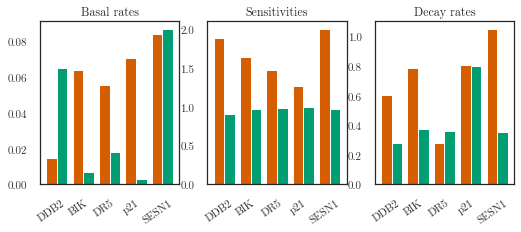

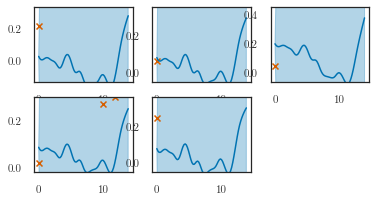

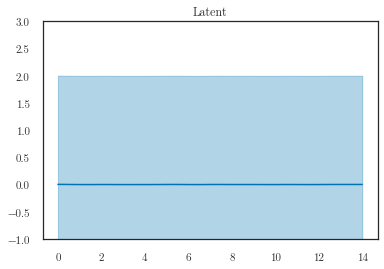

In [6]:
titles = ['Basal rates', 'Sensitivities', 'Decay rates']
kinetics = list()
for key in ['raw_basal', 'raw_sensitivity', 'raw_decay']:
    kinetics.append(
        lfm.positivity.transform(trainer.parameter_trace[key][-1].squeeze()).numpy())
kinetics = np.array(kinetics)

plotter.plot_double_bar(kinetics,
                        ground_truths=P53Data.params_ground_truth(),
                        titles=titles)
q_m = lfm.predict_m(t_predict, step_size=1e-1)
q_f = lfm.predict_f(t_predict)

plotter.plot_gp(q_m, t_predict, replicate=0,
                t_scatter=dataset.t_observed,
                y_scatter=dataset.m_observed, num_samples=0)
plotter.plot_gp(q_f, t_predict, ylim=(-1, 3))
plt.title('Latent')

In [7]:
lfm.set_mode(TrainMode.GRADIENT_MATCH)
# lfm.loss_fn.num_data = 61
# pre_estimator.train(50, report_interval=20);

In [8]:
lfm.set_mode(TrainMode.NORMAL)
lfm.loss_fn.num_data = num_training
trainer.train(200, report_interval=10, step_size=step_size);

Epoch 001/200 - Loss: 15.02 (15.02 0.00) kernel: [0.6831972]
Epoch 011/200 - Loss: 7.28 (6.64 0.64) kernel: [0.64053243]
Epoch 021/200 - Loss: 6.93 (6.20 0.73) kernel: [0.6474696]
Epoch 031/200 - Loss: 6.54 (5.75 0.79) kernel: [0.6588794]
Epoch 041/200 - Loss: 6.28 (5.44 0.85) kernel: [0.65666217]
Epoch 051/200 - Loss: 6.07 (5.18 0.88) kernel: [0.65438545]
Epoch 061/200 - Loss: 5.70 (4.76 0.94) kernel: [0.66446114]
Epoch 071/200 - Loss: 5.39 (4.40 0.99) kernel: [0.6649706]
Epoch 081/200 - Loss: 5.08 (4.02 1.05) kernel: [0.6657042]
Epoch 091/200 - Loss: 4.77 (3.67 1.11) kernel: [0.66185975]
Epoch 101/200 - Loss: 4.46 (3.29 1.17) kernel: [0.6630209]
Epoch 111/200 - Loss: 4.20 (2.99 1.21) kernel: [0.6603851]
Epoch 121/200 - Loss: 3.81 (2.54 1.27) kernel: [0.6605677]
Epoch 131/200 - Loss: 3.51 (2.18 1.34) kernel: [0.6688144]
Epoch 141/200 - Loss: 3.26 (1.86 1.40) kernel: [0.66367996]
Epoch 151/200 - Loss: 2.95 (1.48 1.47) kernel: [0.66337615]
Epoch 161/200 - Loss: 2.65 (1.12 1.53) kernel: 

MultitaskMultivariateNormal(loc: torch.Size([80]))

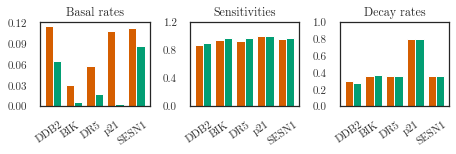

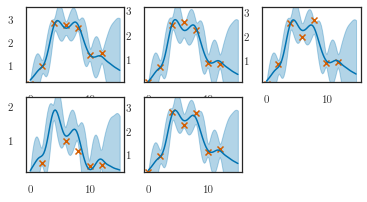

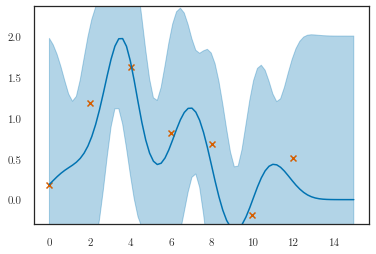

In [9]:
t_predict = torch.linspace(0, t_end+3, 80, dtype=torch.float32)

# plotter.plot_losses(trainer, last_x=200)
q_m = lfm.predict_m(t_predict, step_size=1e-1)
q_f = lfm.predict_f(t_predict)


titles = ['Basal rates', 'Sensitivities', 'Decay rates']
kinetics = list()
for key in ['raw_basal', 'raw_sensitivity', 'raw_decay']:
    kinetics.append(
        lfm.positivity.transform(trainer.parameter_trace[key][-1].squeeze()).numpy())
kinetics = np.array(kinetics)
plotter.plot_double_bar(kinetics,
                        ground_truths=P53Data.params_ground_truth(),
                        titles=titles,
                        figsize=(6.5, 2.3),
                        yticks=[
                            np.linspace(0, 0.12, 5),
                            np.linspace(0, 1.2, 4),
                            np.arange(0, 1.1, 0.2),
                        ])


plt.tight_layout()
# plt.savefig('./kinetics.pdf', **tight_kwargs)

plotter.plot_gp(q_m, t_predict,
                t_scatter=dataset.t_observed, y_scatter=dataset.m_observed)
plotter.plot_gp(q_f, t_predict, t_scatter=dataset.t_observed, y_scatter=dataset.f_observed)
